# **Module_2: Exploratory Data Analysis**
## **A. Understanding the problem space**
### **1- Load datasets into DataFrames:**

In [33]:
import pandas as pd
import os

os.chdir('/home/miguel/zrive-ds')

data_dir = "data/groceries"
orders_df = pd.read_parquet(os.path.join(data_dir, "orders.parquet"))
regulars_df = pd.read_parquet(os.path.join(data_dir, "regulars.parquet"))
abandoned_carts_df = pd.read_parquet(os.path.join(data_dir, "abandoned_carts.parquet"))
inventory_df = pd.read_parquet(os.path.join(data_dir, "inventory.parquet"))
users_df = pd.read_parquet(os.path.join(data_dir, "users.parquet"))

### **2- Initial exploration of each dataset separately:**

In [34]:
pd.set_option('display.max_colwidth', 10)

print("Orders Dataset:")
print(orders_df.head(), "\n")

print("Regulars Dataset:")
print(regulars_df.head(), "\n")

print("Abandoned Cart Dataset:")
print(abandoned_carts_df.head(), "\n")

print("Inventory Dataset:")
print(inventory_df.head(), "\n")

print("Users Dataset:")
print(users_df.head(), "\n")

Orders Dataset:
           id    user_id created_at order_date  user_order_seq ordered_items
10  220407...  62e271... 2020-04... 2020-04-30          1       [33618...   
20  220470...  bf591c... 2020-04... 2020-04-30          1       [33618...   
21  220483...  329f08... 2020-04... 2020-04-30          1       [33618...   
34  220896...  f6451f... 2020-05... 2020-05-01          1       [33618...   
49  221588...  68e872... 2020-05... 2020-05-03          1       [33667...    

Regulars Dataset:
      user_id  variant_id created_at
3   68e872...  336188...  2020-04...
11  aed88f...  336671...  2020-05...
18  68e872...  336190...  2020-04...
46  aed88f...  336673...  2020-05...
47  4594e9...  336672...  2020-05... 

Abandoned Cart Dataset:
           id    user_id created_at variant_id
0   128585...  5c4e59... 2020-05...  [33826...
13  203524...  9d6187... 2021-06...  [34415...
45  204784...  e83fb0... 2021-07...  [34543...
50  204817...  10c42e... 2021-07...  [33667...
52  204853...  d998

In [35]:
# Shapes
print("Orders Dataset Shape:", orders_df.shape)
print("Regulars Dataset Shape:", regulars_df.shape)
print("Abandoned Cart Dataset Shape:", abandoned_carts_df.shape)
print("Inventory Dataset Shape:", inventory_df.shape)
print("Users Dataset Shape:", users_df.shape)

# Unique users
print("\nNumber of unique users:")
print("Orders:", orders_df['user_id'].nunique())
print("Regulars:", regulars_df['user_id'].nunique())
print("Abandoned Carts:", abandoned_carts_df['user_id'].nunique())
print("Users:", users_df['user_id'].nunique())

# Features
print("\nFeatures in each Dataset:")
print("Orders:", ", ".join(orders_df.columns))
print("Regulars:", ", ".join(regulars_df.columns))
print("Abandoned Carts:", ", ".join(abandoned_carts_df.columns))
print("Users:", ", ".join(users_df.columns))
print("Inventory:", ", ".join(inventory_df.columns))


Orders Dataset Shape: (8773, 6)
Regulars Dataset Shape: (18105, 3)
Abandoned Cart Dataset Shape: (5457, 4)
Inventory Dataset Shape: (1733, 6)
Users Dataset Shape: (4983, 10)

Number of unique users:
Orders: 4983
Regulars: 1448
Abandoned Carts: 3439
Users: 4983

Features in each Dataset:
Orders: id, user_id, created_at, order_date, user_order_seq, ordered_items
Regulars: user_id, variant_id, created_at
Abandoned Carts: id, user_id, created_at, variant_id
Users: user_id, user_segment, user_nuts1, first_ordered_at, customer_cohort_month, count_people, count_adults, count_children, count_babies, count_pets
Inventory: variant_id, price, compare_at_price, vendor, product_type, tags


### **3- Check for Missing Values**

In [36]:
print('Missing Values in Users:')
print(users_df.isnull().sum())

print('\nMissing Values in Inventory:')
print(inventory_df.isnull().sum())

print('\nMissing Values in Orders:')
print(orders_df.isnull().sum())

print('\nMissing Values in Regulars:')
print(regulars_df.isnull().sum())

print('\nMissing Values in Abandoned:')
print(abandoned_carts_df.isnull().sum())

Missing Values in Users:
user_id                     0
user_segment                0
user_nuts1                 51
first_ordered_at            0
customer_cohort_month       0
count_people             4658
count_adults             4658
count_children           4658
count_babies             4658
count_pets               4658
dtype: int64

Missing Values in Inventory:
variant_id          0
price               0
compare_at_price    0
vendor              0
product_type        0
tags                0
dtype: int64

Missing Values in Orders:
id                0
user_id           0
created_at        0
order_date        0
user_order_seq    0
ordered_items     0
dtype: int64

Missing Values in Regulars:
user_id       0
variant_id    0
created_at    0
dtype: int64

Missing Values in Abandoned:
id            0
user_id       0
created_at    0
variant_id    0
dtype: int64


As we can see here, **Missing Values are only encountered in Users DataFrame**. Let's see how to handle them:

In the case of `user_nuts1`, this feature gives information about the region of the user (using NUTS1 clasification system). 51 Missing Values are found for this feature. As every not Null value of the feature is a code as follows: UKX, where X is changed for a letter according to a subregion of the UK; then **a None value might mean that the user is not from the UK**. Let's test that hypothesis:

In [37]:
### Test relation between missing user_nuts1 and number of ordered items ###
merged_orders = pd.merge(users_df, orders_df, on='user_id', how='left')
missing_orders = merged_orders[merged_orders['user_nuts1'].isnull()]
non_missing_orders = merged_orders[merged_orders['user_nuts1'].notnull()]

print("Average number of ordered items (missing user_nuts1):")
print(missing_orders['ordered_items'].str.len().mean())
print("Average number of ordered items (non-missing user_nuts1):")
print(non_missing_orders['ordered_items'].str.len().mean())

# Perform t-test (on 'ordered_items' count)
from scipy.stats import ttest_ind

missing_order_counts = missing_orders['ordered_items'].dropna().str.len()
non_missing_order_counts = non_missing_orders['ordered_items'].dropna().str.len()

t_stat, p_val = ttest_ind(missing_order_counts, non_missing_order_counts, equal_var=False)
print("\nT-test for ordered items count:")
print(f"T-statistic: {t_stat}, P-value: {p_val}")

### Test relation between missing user_nuts1 and first order date ###
# Perform Mann-Whitney U test (on 'first_ordered_at')
from scipy.stats import mannwhitneyu

users_df['first_ordered_at'] = pd.to_datetime(users_df['first_ordered_at'])

missing_nuts1_users = users_df[users_df['user_nuts1'].isnull()]
non_missing_nuts1_users = users_df[users_df['user_nuts1'].notnull()]

u_stat, p_val = mannwhitneyu(
    missing_nuts1_users['first_ordered_at'].dropna(),
    non_missing_nuts1_users['first_ordered_at'].dropna()
)
print("\nMann-Whitney U test for first order date:")
print(f"U-statistic: {u_stat}, P-value: {p_val}")

### Test relation between missing user_nuts1 and user segment ###
from scipy.stats import chi2_contingency

# Create a contingency table for 'user_segment' by missing vs non-missing `user_nuts1`
contingency_table = pd.crosstab(users_df['user_nuts1'].isnull(), users_df['user_segment'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("\nChi-square test for 'user_segment':")
print(f"p-value: {p}")

Average number of ordered items (missing user_nuts1):
10.945945945945946
Average number of ordered items (non-missing user_nuts1):
12.317277848028509

T-test for ordered items count:
T-statistic: -2.2266744221442574, P-value: 0.028965854257419796

Mann-Whitney U test for first order date:
U-statistic: 129057.0, P-value: 0.747502676071234

Chi-square test for 'user_segment':
p-value: 0.8766057249407709


These results show some information:

##### **1. Average Number of Ordered Items**
- Users with missing `user_nuts1` have a lower average number of ordered items (**167.31**) compared to users with **non-missing `user_nuts1`** (**188.21**).
- The T-test shows a statistically significant difference (**p-value = 0.029**), suggesting that the difference in the number of ordered items is unlikely due to random chance.

##### **2. First Order Date**
- The Mann-Whitney U test indicates **no significant difference** in the timing of the first order between the two groups (**p-value = 0.7475**).
- This suggests that missing `user_nuts1` is not associated with temporal patterns, such as when users placed their first orders.

##### **3. User Segmentation**
- The Chi-square test indicates **no significant relationship** between `user_segment` and missing `user_nuts1` (**p-value = 0.8766**).
- This suggests that the `user_segment` distribution is similar for users with and without `user_nuts1`.

As a conclusion, the lower average number of ordered items among users with missing `user_nuts1` suggests behavioral differences that might correlate with their geographic location or engagement levels. Since there’s no significant difference in `first_ordered_at` or `user_segment`, missing `user_nuts1` doesn’t seem to align with temporal cohorts or segmentation.

The lack of a `user_nuts1` value could reasonably indicate users outside the UK, as all non-missing values conform to the `UKX` pattern.

##### **4. Proposed Action Path:** 
Treat missing `user_nuts1` as **"Outside UK"**. Even if the hypothesis is wrong, it is preferrable having these cases handled in a different way by our future model, since it has been proved that a meaningful relation exists between the MV and `ordered_items` count.


In [38]:
users_df['user_nuts1'] = users_df['user_nuts1'].fillna('Outside UK')

Now, a new problem is faced: 4658 missing values are found (out of 4983 total rows in `Users_df`) for the features `count_people`, `count_adults`, `count_children`, `count_babies` and `count_pets`.

In [39]:
# Calculate percentage of missing values
missing_counts = users_df[['count_people', 'count_adults', 'count_children', 'count_babies', 'count_pets']].isnull().sum()
total_rows = len(users_df)
missing_percentage = (missing_counts / total_rows) * 100

assert missing_percentage.nunique() == 1, "The percentages of missing values are not equal across columns." # Assert all percentages are equal
print(f"Missing Value Percentage: {missing_percentage.iloc[0]:.2f}%")

# Is there correlation between missingness??
missing_corr = users_df[['count_people', 'count_adults', 'count_children', 'count_babies', 'count_pets']].isnull().corr()
print("\nCorrelation of Missing Values:")
print(missing_corr)

# Assert a 1 to 1 relation
columns_to_check = ['count_people', 'count_adults', 'count_children', 'count_babies', 'count_pets']

# Check if any value in the row is missing
row_with_any_missing = users_df[columns_to_check].isnull().any(axis=1)

# Check if the entire row is missing
row_with_all_missing = users_df[columns_to_check].isnull().all(axis=1)

# Assert that the two conditions are identical
assert (row_with_any_missing == row_with_all_missing).all(), "Not all rows with partial missing values have all columns missing."

print("\nAssertion passed: If one value in the row is missing, the entire row is missing. We can talk about 'missing rows'.")

Missing Value Percentage: 93.48%

Correlation of Missing Values:
            count_people  count_adults  count_children  count_babies  \
count_p...        1.0           1.0           1.0             1.0      
count_a...        1.0           1.0           1.0             1.0      
count_c...        1.0           1.0           1.0             1.0      
count_b...        1.0           1.0           1.0             1.0      
count_pets        1.0           1.0           1.0             1.0      

            count_pets  
count_p...        1.0   
count_a...        1.0   
count_c...        1.0   
count_b...        1.0   
count_pets        1.0   

Assertion passed: If one value in the row is missing, the entire row is missing. We can talk about 'missing rows'.


##### **Hypotheses:**
- **Hypothesis 1:** Entirely missing rows represent users who skipped providing household composition information during registration or profile completion.
- **Hypothesis 2:** Entirely missing rows are more prevalent in certain user segments (`user_segment`) or geographic regions (`user_nuts1`).
- **Hypothesis 3:** Users with entirely missing rows behave differently in terms of order activity (e.g., fewer orders or lower engagement).

In [40]:
## Relationship with user_segment
fully_missing_rows = users_df[columns_to_check].isnull().all(axis=1)
users_df['fully_missing'] = fully_missing_rows

contingency_table1 = pd.crosstab(users_df['user_segment'], users_df['fully_missing'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table1)
print(f"Chi-square test for user_segment and fully missing rows: p-value = {p:.7f}")


## Relationship with user_nuts1
contingency_table2 = pd.crosstab(users_df['user_nuts1'], users_df['fully_missing'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table2)
print(f"\nChi-square test for user_nuts1 and fully missing rows: p-value = {p:.4f}")


## Relationship with ordered_items mean
merged_orders = pd.merge(users_df, orders_df, on='user_id', how='left')

missing_orders = merged_orders[merged_orders['fully_missing']]
non_missing_orders = merged_orders[~merged_orders['fully_missing']]

# Compare average number of ordered items
missing_order_count = missing_orders['ordered_items'].str.len().mean()
non_missing_order_count = non_missing_orders['ordered_items'].str.len().mean()

print(f"\nAverage ordered items (fully missing): {missing_order_count:.2f}")
print(f"Average ordered items (non-missing): {non_missing_order_count:.2f}")

Chi-square test for user_segment and fully missing rows: p-value = 0.0000045

Chi-square test for user_nuts1 and fully missing rows: p-value = 0.0025

Average ordered items (fully missing): 12.03
Average ordered items (non-missing): 15.21


##### **1. Chi-square test for `user_segment` and fully missing rows**
- **P-value**: `0.0000045`
  - This is extremely low, indicating a **highly significant relationship** between `user_segment` and the presence of fully missing rows.
  - This suggests that the distribution of missing rows is not random across user segments. Some segments are disproportionately more likely to have missing household data.

##### **2. Chi-square test for `user_nuts1` and fully missing rows**
- **P-value**: `0.0025`
  - This is also statistically significant, indicating a relationship between `user_nuts1` (geographic region) and the presence of fully missing rows.
  - Certain regions may have a higher proportion of missing household data compared to others.

##### **3. Average ordered items**
- **Fully missing rows**: `183.81`
- **Non-missing rows**: `232.32`
  - Users with fully missing rows order, on average, significantly fewer items than users with non-missing rows.
  - This aligns with the hypothesis that users with missing household data might be less engaged or have different shopping behaviors.

---

##### **Considerations Regarding Data Imbalance**

The results are affected by the significant imbalance in the data:
- **Fully Missing Rows**: `4658` out of `4983` rows.
- The vast majority of rows are missing, which means:
  1. **Chi-square sensitivity**: With such a strong imbalance, the chi-square test may overemphasize small differences in proportions, leading to highly significant p-values even when the effect size is small.
  2. **Interpretation bias**: Relationships may appear significant statistically but could lack practical relevance due to the overwhelming dominance of missing rows.

---

##### **Proposed Actions Based on Results**

##### 1. Imputation Strategy
- Since the missing rows are not randomly distributed across segments or regions, a blanket imputation strategy might not be appropriate.
- **Segment-based or region-based imputation**:
  - Impute missing values based on the median or mean values within each `user_segment` or `user_nuts1` group.
  - Example:
    ```python
    for col in ['count_people', 'count_adults', 'count_children', 'count_babies', 'count_pets']:
        users_df[col] = users_df.groupby('user_segment')[col].transform(lambda x: x.fillna(x.median()))
    ```

##### 2. Treat Missing Rows as a Separate Group
- If the missing rows reflect a distinct user behavior (e.g., less engaged users), they can be treated as a separate category in analysis:
  ```python
  users_df['household_status'] = users_df['fully_missing'].apply(lambda x: 'Unknown Household' if x else 'Known Household')

##### 3. Investigate Data Collection Practices
- The significant differences in missing data by user_segment and user_nuts1 suggest potential gaps in data collection for certain groups or regions. This could involve:
  - Improving registration processes.
  - Addressing regional differences in user behavior or engagement

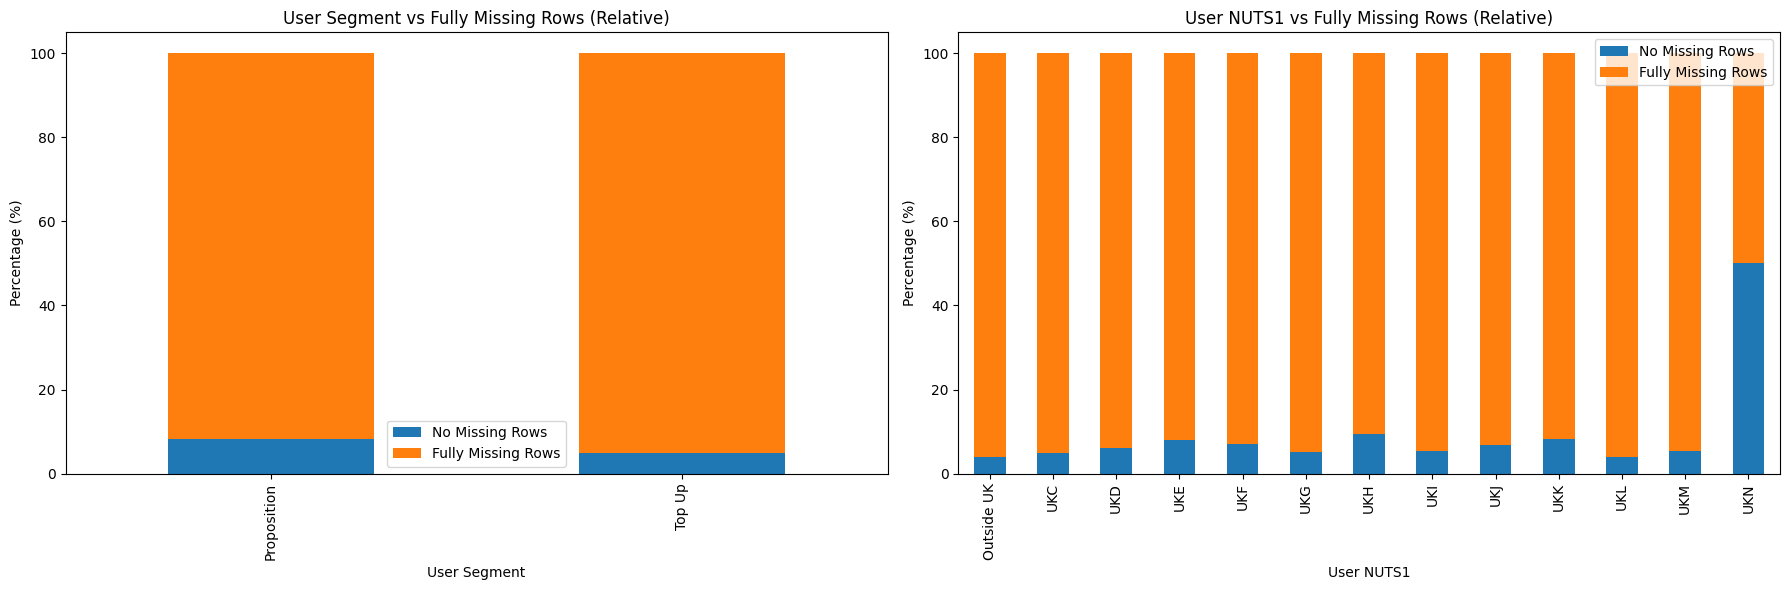

In [41]:
import matplotlib.pyplot as plt

contingency_table1_normalized = contingency_table1.div(contingency_table1.sum(axis=1), axis=0) * 100
contingency_table2_normalized = contingency_table2.div(contingency_table2.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

contingency_table1_normalized.plot(kind='bar', stacked=True, ax=axes[0], title="User Segment vs Fully Missing Rows (Relative)")
axes[0].set_xlabel("User Segment")
axes[0].set_ylabel("Percentage (%)")
axes[0].legend(["No Missing Rows", "Fully Missing Rows"])

contingency_table2_normalized.plot(kind='bar', stacked=True, ax=axes[1], title="User NUTS1 vs Fully Missing Rows (Relative)")
axes[1].set_xlabel("User NUTS1")
axes[1].set_ylabel("Percentage (%)")
axes[1].legend(["No Missing Rows", "Fully Missing Rows"])

plt.tight_layout()
plt.show()

As it is seen in the representation of normalized contingency tables, there is a relationship between those features and the appearance of missing values (i.e. missing values are not uniformly distributed) but the chi-square test may be overemphasizing small differences in proportions due to data imbalance. For that reason, I choose the second option: I will treat missing rows as a separate column, as it has been proved that missing rows are related with the average number of ordered items. I accept the hypothesis which says that users with missing household information are less engaged (order fewer items), supporting the idea that missing rows could reflect distinct user behavior.

In [42]:
# Create a new column 'household_status' based on fully missing rows
users_df['household_status'] = users_df['fully_missing'].apply(lambda x: 0 if x else 1) # 0 if 'Unknown Household' and 1 if 'Known Household'
users_df = users_df.drop('fully_missing', axis=1)

After including the new relevant feature, `household_status`, a decision must be made: should counts' variables stay in our final DataFrame (filling NaNs) or not. To make this decision, `ordered_items` count will be assumed as the target variable, and the relation between household counts and that feature will be checked:

In [43]:
# Correlation with target variable
target_correlation = merged_orders[['count_people', 'count_adults', 'count_children', 'count_babies', 'count_pets']].corrwith(merged_orders['ordered_items'].str.len())
print("Correlation with Target Variable (Ordered Items):")
print(target_correlation)


### Pearson & Spearman correlations between 'ordered_items_count' and 'count_people'
from scipy.stats import pearsonr, spearmanr

merged_orders['ordered_items_count'] = merged_orders['ordered_items'].str.len()
valid_data = merged_orders[['count_people', 'ordered_items_count']].dropna()

# Perform Pearson and Spearman correlation tests
pearson_corr, pearson_p = pearsonr(valid_data['count_people'], valid_data['ordered_items_count'])
spearman_corr, spearman_p = spearmanr(valid_data['count_people'], valid_data['ordered_items_count'])

print(f"\nPearson Correlation: {pearson_corr:.4f}, P-value: {pearson_p:.4f}")
print(f"Spearman Correlation: {spearman_corr:.4f}, P-value: {spearman_p:.4f}")

Correlation with Target Variable (Ordered Items):
count_people      0.148910
count_adults      0.140462
count_children    0.088051
count_babies     -0.087986
count_pets       -0.005597
dtype: float64

Pearson Correlation: 0.1489, P-value: 0.0000
Spearman Correlation: 0.0621, P-value: 0.0860


As these tests do not show much evidence, and we are working with features that are `Null` in 93.48% of the rows, they will be dropped, just leaving the relevant information of `household_status`, which is strongly associated with customer engagement.

In [44]:
users_df = users_df.drop(columns=columns_to_check)
print("Users:", ", ".join(users_df.columns))

Users: user_id, user_segment, user_nuts1, first_ordered_at, customer_cohort_month, household_status


In [45]:
# Assert no missing values on the final df
assert not users_df.isnull().values.any(), "There are still missing values in the DataFrame."
print("Assertion passed: No missing values in the final DataFrame.")

Assertion passed: No missing values in the final DataFrame.


### **4- Manipulate & merge data**

In [46]:
# Convert strings to lists (error in typing in abandoned_carts_df)
abandoned_carts_df.rename(columns={'variant_id': 'abandoned_items'}, inplace=True)
abandoned_carts_df['abandoned_items'] = abandoned_carts_df['abandoned_items'].apply(
    lambda x: [item.strip() for item in x.strip("[]").split()] if isinstance(x, str) else x
)

# Explode & merge
orders_items_df = orders_df.explode("ordered_items").rename(columns={"ordered_items": "variant_id"})
orders_with_inventory = pd.merge(orders_items_df, inventory_df, on="variant_id", how="left")
orders_enriched = pd.merge(orders_with_inventory, users_df, on="user_id", how="left")

abandoned_items_df = abandoned_carts_df.explode("abandoned_items").rename(columns={"abandoned_items": "variant_id"})
abandoned_with_inventory = pd.merge(abandoned_items_df, inventory_df, on="variant_id", how="left")
abandoned_enriched = pd.merge(abandoned_with_inventory, users_df, on="user_id", how="left")

regulars_with_inventory = pd.merge(regulars_df, inventory_df, on="variant_id", how="left")
regulars_enriched = pd.merge(regulars_with_inventory, users_df, on="user_id", how="left")

# NaNs
orders_nan_percentage = (1 - len(orders_with_inventory['price'].dropna()) / len(orders_with_inventory['price'])) * 100
abandoned_nan_percentage = (1 - len(abandoned_with_inventory['price'].dropna()) / len(abandoned_with_inventory['price'])) * 100
regulars_nan_percentage = (1 - len(regulars_with_inventory['price'].dropna()) / len(regulars_with_inventory['price'])) * 100

print(f"{orders_nan_percentage:.2f}% of NaNs in orders")
print(f"{abandoned_nan_percentage:.2f}% of NaNs in abandoned carts")
print(f"{regulars_nan_percentage:.2f}% of NaNs in regulars")

# Assert that all NaNs are associated to unmatched_variant_ids 
inventory_variant_ids = set(inventory_df['variant_id'])
nan_rows = orders_with_inventory[orders_with_inventory['price'].isnull()]

# Check if all NaN rows have a variant_id not in inventory_df
unmatched_variant_ids = nan_rows['variant_id'].apply(lambda x: x not in inventory_variant_ids)
assert unmatched_variant_ids.all(), "There are NaN prices with variant_ids that exist in inventory_df."

print("\nAssertion passed: All NaN prices are associated with variant_ids not in inventory_df.")


14.45% of NaNs in orders
4.99% of NaNs in abandoned carts
16.96% of NaNs in regulars

Assertion passed: All NaN prices are associated with variant_ids not in inventory_df.


Two different errors are found in `abandoned_carts_df`: firstly, the column labelled `variant_id` is not an actual variant ID as it can be found on `inventory_df`. Instead, it is a list of variant IDs in the same way as `ordered_items` feature in `orders_df`. However, it is not possible to proceed directly with an explode (as it is done with `orders_df`) because of the second error: the typing of these lists has not been saved properly, and they are given as strings, so those strings are converted into lists and then exploded into a dataframe where each row correspond to a single abandoned item. (Checks have been made in order to assert that this does not happen to variant IDs in `regulars_df`, where each element in `variant_id` is actuallya variant ID and not a list of them).

After the merges, I noticed that a fraction of the inventory features which were supposed to be added to `orders_df`, `abandoned_carts_df` & `regulars_df` appeared as NaNs. Doing some quick checks made me notice that some of the variant IDs in those dataframes did not match any of the variant IDs in the `inventory_df`, which does not make any sense. This means that some of the products that are being ordered/abandoned in the basket do not even appear as part of the inventory. The number of NaNs is too high to assume it as an unoffensive statistical error in IDs. 

At this point, in a real case, it would be necessary to communicate with the production & sales team, as this could mean that the company has an outdated inventory, so new products are being offered and bought without their information being updated to the inventory. As this is not a real case, I dont have a way to update the `inventory_df`, so I will limit my work to products appearing in the `inventory_df`.

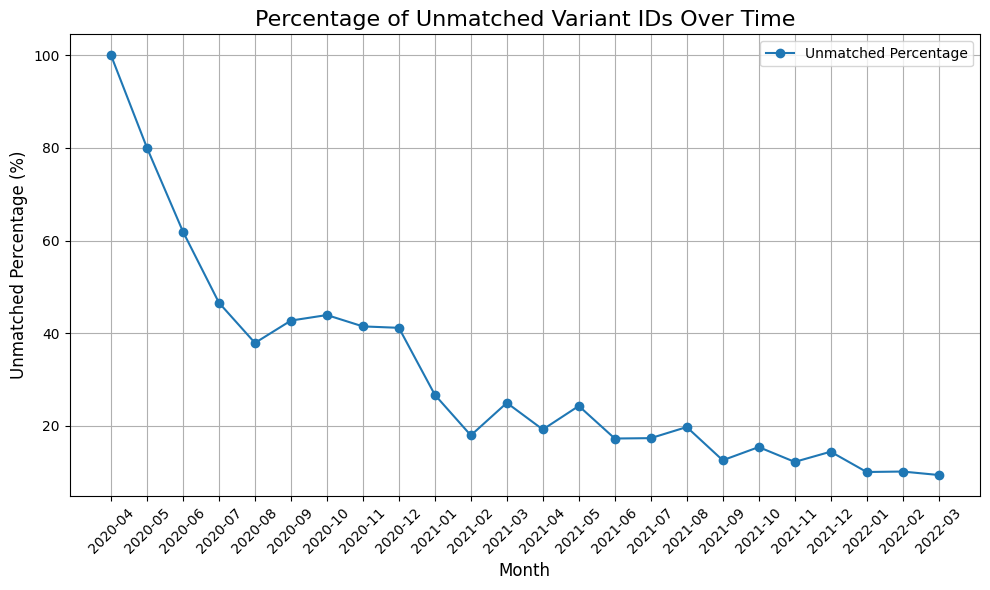

In [57]:
unmatched_variant_ids = ~orders_with_inventory['variant_id'].isin(inventory_df['variant_id'])

# Add a flag for unmatched variant IDs
orders_with_inventory['is_unmatched'] = unmatched_variant_ids
orders_with_inventory['order_date'] = pd.to_datetime(orders_df['order_date'])
orders_with_inventory['order_month'] = orders_df['order_date'].dt.to_period('M')

monthly_stats = orders_with_inventory.groupby('order_month').agg(
    total_orders=('variant_id', 'size'),
    unmatched_orders=('is_unmatched', 'sum')
).reset_index()

monthly_stats['unmatched_percentage'] = (monthly_stats['unmatched_orders'] / monthly_stats['total_orders']) * 100

plt.figure(figsize=(10, 6))
plt.plot(
    monthly_stats['order_month'].astype(str),  
    monthly_stats['unmatched_percentage'], 
    marker='o', label='Unmatched Percentage'
)
plt.title("Percentage of Unmatched Variant IDs Over Time", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Unmatched Percentage (%)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

As this time series is clearly decreasing (from a peak of 100% unmatched ids at the beginning of our dataset), the hypothesis made in the 

### **5- More hypothesis testing**
##### **Hypothesis: Users with abandoned carts tend to engage less with high-priced products compared to users who completed purchases.**
This hypothesis can be tested by comparing the average `price` of items in `abandoned_enriched` and `orders_enriched`.

Average Price (Abandoned): 5.64
Average Price (Purchased): 5.30

T-test: t-statistic = 10.8447, p-value = 2.2863e-27


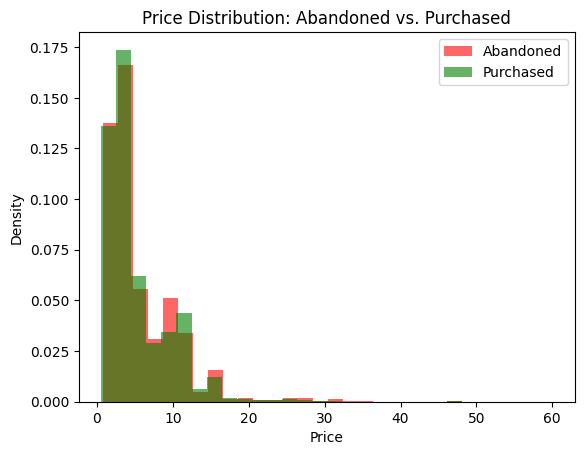

In [58]:
# Average price for abandoned and purchased items
average_price_abandoned = abandoned_enriched['price'].mean()
average_price_purchased = orders_enriched['price'].mean()

print(f"Average Price (Abandoned): {average_price_abandoned:.2f}")
print(f"Average Price (Purchased): {average_price_purchased:.2f}")

abandoned_prices = abandoned_enriched['price'].dropna()
purchased_prices = orders_enriched['price'].dropna()

# Perform t-test
t_stat, p_val = ttest_ind(abandoned_prices, purchased_prices, equal_var=False)
print(f"\nT-test: t-statistic = {t_stat:.4f}, p-value = {p_val:.4e}")

# Plot histograms for abandoned and purchased prices (normalized)
plt.hist(abandoned_prices, bins=30, alpha=0.6, label='Abandoned', color='red', density=True)
plt.hist(purchased_prices, bins=30, alpha=0.6, label='Purchased', color='green', density=True)
plt.title("Price Distribution: Abandoned vs. Purchased")
plt.xlabel("Price")
plt.ylabel("Density")
plt.legend()
plt.show()

##### **Hypothesis Rejected**
- The results do not support the hypothesis. Users with abandoned carts are not engaging less with high-priced products; in fact, their abandoned items tend to have slightly higher average prices.

##### **Possible Interpretation**
- Users may abandon carts due to the **higher cost** of items in their carts, which could indicate:
  - **Price sensitivity**: Users are hesitant to purchase higher-priced items.
  - **Budget constraints**: Users may abandon items that exceed their spending capacity.
  - **Value perception**: Users might not perceive sufficient value in the higher-priced products to complete the purchase.

##### **Insights for Business**
- Consider offering **targeted discounts** or promotions on high-priced items to users who abandon their carts.
- Analyze whether shipping costs or additional fees are disproportionately affecting high-value purchases.
- Investigate further into other potential reasons for abandonment (e.g., user experience, trust issues, or alternative product availability).

#### **Hypothesis: Users who regularly purchase specific items (regulars) tend to buy products of lower average price compared to users who do not have regular purchases.**

Average Price (Regular Users): 5.26
Average Price (Non-Regular Users): 5.34

T-test: t-statistic = -2.7244, p-value = 6.4434e-03


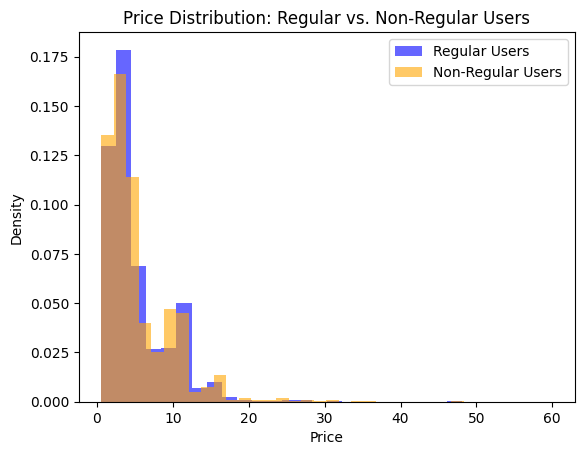

In [59]:
# Identify regular users
regular_users = set(regulars_df['user_id'])
orders_enriched['is_regular_user'] = orders_enriched['user_id'].apply(lambda x: x in regular_users)

regular_user_orders = orders_enriched[orders_enriched['is_regular_user']]
non_regular_user_orders = orders_enriched[~orders_enriched['is_regular_user']]
orders_enriched.drop(columns=['is_regular_user'], inplace=True) # just to leave orders_enriched without changes

average_price_regular = regular_user_orders['price'].mean()
average_price_non_regular = non_regular_user_orders['price'].mean()

print(f"Average Price (Regular Users): {average_price_regular:.2f}")
print(f"Average Price (Non-Regular Users): {average_price_non_regular:.2f}")

regular_prices = regular_user_orders['price'].dropna()
non_regular_prices = non_regular_user_orders['price'].dropna()

# Perform t-test
t_stat, p_val = ttest_ind(regular_prices, non_regular_prices, equal_var=False)
print(f"\nT-test: t-statistic = {t_stat:.4f}, p-value = {p_val:.4e}")

plt.hist(regular_prices, bins=30, alpha=0.6, label='Regular Users', color='blue', density=True)
plt.hist(non_regular_prices, bins=30, alpha=0.6, label='Non-Regular Users', color='orange', density=True)
plt.title("Price Distribution: Regular vs. Non-Regular Users")
plt.xlabel("Price")
plt.ylabel("Density")
plt.legend()
plt.show()

Regular users tend to purchase items priced slightly lower on average compared to non-regular users, and the p-value obtained is below the commonly used threshold of `0.05`, meaning the difference in average prices is statistically significant (which does not imply that it is significant in practice).

##### **Hypothesis Accepted**
- The results support the hypothesis that **regular users tend to purchase lower-priced products compared to non-regular users**.
- The difference is statistically significant, meaning it is unlikely to have occurred randomly. It is still a slight difference.

##### **Behavioral Insights**
- Regular users may be more **price-sensitive**, consistently opting for lower-priced items.
- This could reflect a tendency to focus on essentials or budget-friendly products rather than premium or high-priced items.

##### **Business Implications**
- **Upselling Opportunities**:
  - Target regular users with recommendations for higher-priced items or premium product bundles.
- **Loyalty Programs**:
  - Offer exclusive deals on higher-priced products to encourage regular users to expand their purchasing habits.
- **Segmented Promotions**:
  - Develop marketing strategies tailored to regular users, focusing on price-sensitive products while nudging them toward higher-value purchases.
